<p><h1>Graphs of airline sentiment using emojis</h1>
Aim is to produce some initial graphs giving indications of sentiment with very little analysis, including:
<ul><li>The top x emojis associated with each airline (and their sentiment)</li>
    <li>Proportion of tweets to each airline that include an emoji</li>
    <li>Mean sentiment for each airline using the sentiment of the emojis tweeted at them</li>
</ul>
</p>

<p><h2>Processing Tweets and collecting sentiment</h2>Import emosent package and read csv file</p>

In [1]:
from emosent import get_emoji_sentiment_rank
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import csv
from emoji import UNICODE_EMOJI

# open csv file
tweets = []
with open('data/Tweets.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    next(reader)
    for row in reader:
        filtered_row = [row[5], row[10]]
        tweets.append(filtered_row)
        

#dataframe = pd.read_csv("Tweets.csv")
#dataframe = dataframe[["airline", "text"]]

<p>isEmoji Function checks if character is an emoji, using the emosent function (if it is passed a non-emoji it raises a KeyError so am using that here to determine if a character is an emoji).</p>

In [2]:
def isEmoji(character):
    try:
        # if character can be found by emosent module return true
        get_emoji_sentiment_rank(character)
        return True
    except KeyError:
        return False

<p>2D dictionary to store Tweet data for each airline</p>

In [3]:
airlines = {}
for airline in ["Virgin America", "United", "Southwest","Delta", "US Airways", "American"]:
    airlines[airline] = {"emojis":{},
                          "number_tweets":0,
                          "number_emoji_tweets":0,
                          "sentiment_sum":0}

<p>Iterate through tweets to count number of emojis per tweet, get sentiment data and sum this</p>

In [4]:
for tweet in tweets:
    airline = tweet[0]
    # update overall tweet_count for airline
    airlines[airline]["number_tweets"] += 1
    emojis = {}
    for character in tweet[1]:
        if isEmoji(character):
            if character in emojis:
                emojis[character] += 1
            else:
                emojis[character] = 1
    if emojis:
        # update emoji_tweet counter for this airline
        airlines[airline]["number_emoji_tweets"] += 1
        emoji_sentiment_in_tweet = 0
        num_emojis_in_tweet = 0
        for emoji in emojis: 
            # multiply sentiment by number occurrences
            emoji_sentiment_in_tweet += emojis[emoji] * get_emoji_sentiment_rank(emoji)['sentiment_score']
            num_emojis_in_tweet += emojis[emoji]
            
            # add to dictionary of emojis tweeted at the airline
            if emoji in airlines[airline]["emojis"]:
                airlines[airline]["emojis"][emoji] += 1
            else:
                airlines[airline]["emojis"][emoji] = 1
                
        # average out by number of emojis
        emoji_sentiment_in_tweet = emoji_sentiment_in_tweet / num_emojis_in_tweet
        airlines[airline]["sentiment_sum"] += emoji_sentiment_in_tweet

<p>Divide sentiment sum by number emoji tweets for each airline</p>

In [5]:
for airline in airlines:
    airlines[airline]['sentiment_sum'] = airlines[airline]['sentiment_sum'] / airlines[airline]['number_emoji_tweets']
    airlines[airline]['emoji_proportion'] = 100 * airlines[airline]['number_emoji_tweets'] / airlines[airline]['number_tweets']


In [6]:
num_tweets = []
num_em_tweets = []
sentiments = []
proportion = []
for airline in airlines:
    num_tweets.append(airlines[airline]['number_tweets'])
    num_em_tweets.append(airlines[airline]['number_emoji_tweets'])
    sentiments.append(airlines[airline]['sentiment_sum'])
    proportion.append(airlines[airline]['emoji_proportion'])
trimmed = {'Airline' : list(airlines.keys()), 'Total Tweets':num_tweets,'Tweets Including Emojis':num_em_tweets, 'Proportion of Tweets with Emojis (%)':proportion, 'Average Airline Sentiment Using Emoji Sentiment':sentiments}
df = pd.DataFrame(data=trimmed)
df

,Airline,Total Tweets,Tweets Including Emojis,Proportion of Tweets with Emojis (%),Average Airline Sentiment Using Emoji Sentiment
0,Virgin America,504,39,7.738095,0.394529
1,United,3822,62,1.622187,0.281344
2,Southwest,2420,119,4.917355,0.300232
3,Delta,2222,148,6.660666,0.269021
4,US Airways,2913,60,2.059732,0.201521
5,American,2759,63,2.283436,0.193684


<p><h2>Graphs</h2><h3>Proportion (%) of Tweets that include emojis</h3> Virgin America is the clear leader.</p>

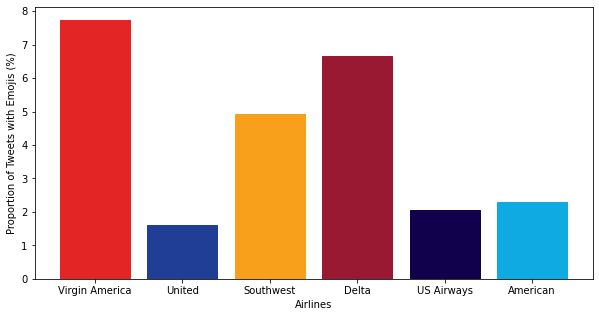

In [55]:
#df = df.sort_values(by=['proportion of tweets with emojis'])
fig, ax = plt.subplots(figsize=(10, 5))
props = ax.bar(list(airlines.keys()), proportion)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation='horizontal')

plt.xlabel('Airlines')
plt.ylabel("Proportion of Tweets with Emojis (%)")
props[0].set_color('#E32525')
props[1].set_color('#213E96')
props[2].set_color('#F8A01B')
props[3].set_color('#991932')
props[4].set_color('#11004C')
props[5].set_color('#0FAAE2')
plt.show()
fig.savefig('proportion.png')
#proportion_ax = df.plot.bar(x='Airline', y='proportion of tweets with emojis')

<p><h3>Sentiment as predicted by emojis</h3>Virgin America is again the clear leader.</p>

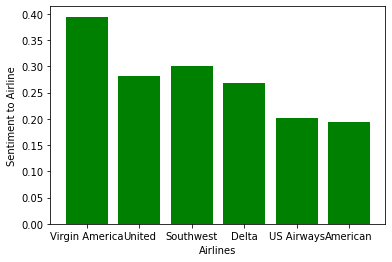

In [9]:
plt.bar(list(airlines.keys()), sentiments, color='green')
plt.xlabel('Airlines')
plt.ylabel('Sentiment to Airline')
plt.show()

<p><h3>Proportion of tweets using emojis against sentiment</h3>A rough positive correlation.</p>

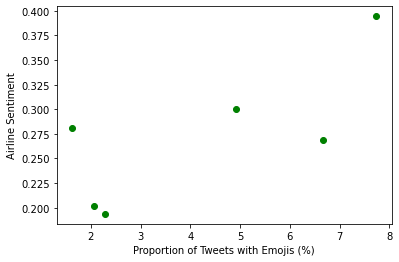

In [10]:
plt.scatter(proportion, sentiments, color='green')
plt.xlabel('Proportion of Tweets with Emojis (%)')
plt.ylabel('Airline Sentiment')
plt.show()

<p><h3>Top 10 emojis for each airline</h3>Surprisingly few used.</p>

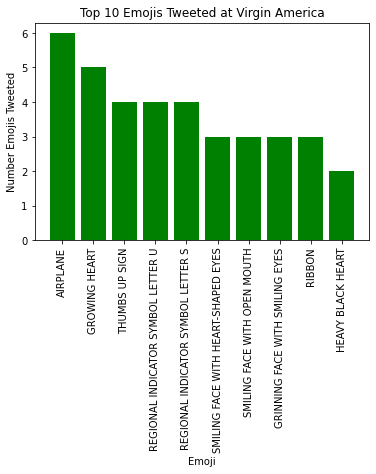

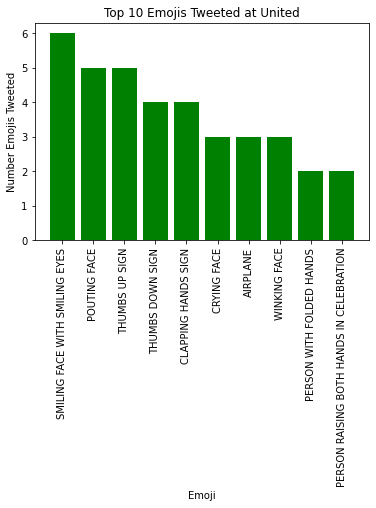

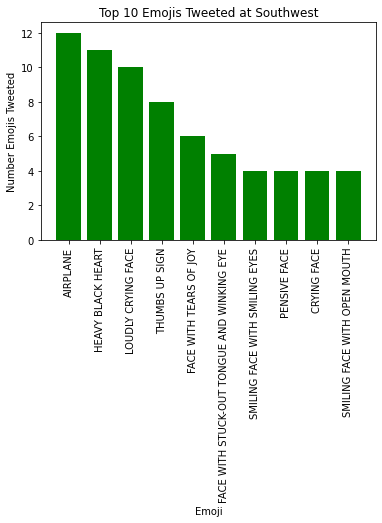

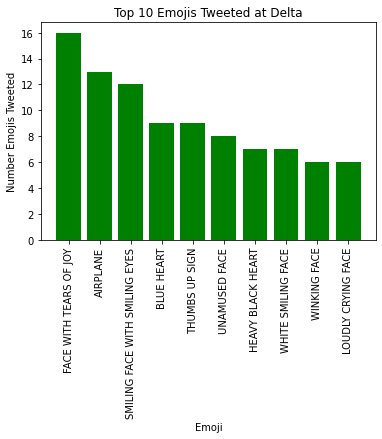

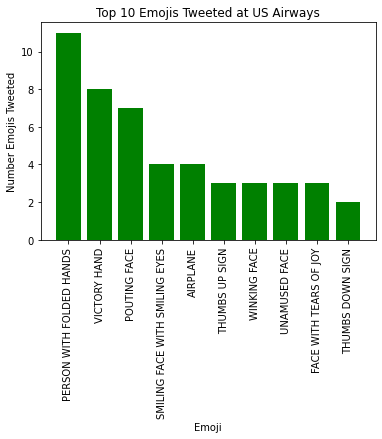

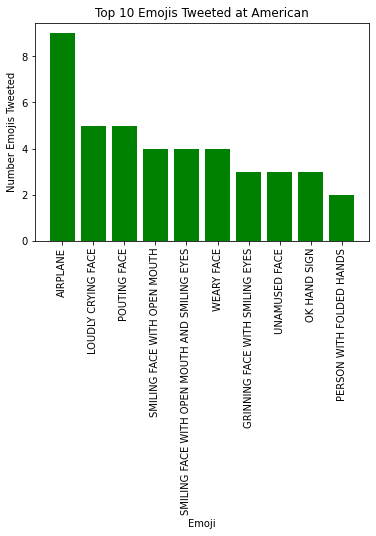

In [11]:
for airline in airlines:
    # get a list of emojis and their frequency of use
    emojis = []
    for emoji in airlines[airline]['emojis']:
        emojis.append([emoji, airlines[airline]['emojis'][emoji]])
    # sort by the frequency of emoji use
    emojis = sorted(emojis, key=lambda l:l[1], reverse=True)

    # separate into two columns of the 10 most popular emojis
    #use the unicode name instead of the actual emoji because matplotlib struggles displaying properly
    emoji_vals = [get_emoji_sentiment_rank(x[0])['unicode_name'] for x in emojis[:10]]
    frequency_vals = [x[1] for x in emojis[:10]]
   
    plt.bar(range(len(emoji_vals)), frequency_vals, color='green')
    plt.xticks(range(len(emoji_vals)), emoji_vals, rotation=90)
    plt.xlabel('Emoji')
    plt.ylabel('Number Emojis Tweeted')
    plt.title('Top 10 Emojis Tweeted at '+airline)
    plt.show()
